In [25]:
pip install linearmodels

In [26]:
from toolz import *

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

# 24 - The Difference-in-Differences Saga

After discussing treatment effect heterogeneity, we will now switch gears a bit, back into average treatment effects. Over the next few chapters, we will cover some recent developments in panel data methods. A panel is a data structure that has repeated observations across time. The fact that we observe the same unit in multiple time periods allows us to see what happens before and after a treatment takes place. This makes panel data a promising alternative to identifying the causal effects when randomization is not possible.

To motivate the use of panel data, we will mostly talk about causal inference applications to marketing. Marketing is particularly interesting for its notorious difficulty in running randomized experiments. In marketing, we often can't control who receives the treatment, that is, who sees our advertisements. When a new user comes to our site or downloads our app, we have no good way of knowing if that user came because he or she saw one of our campaigns or due to some other factor.

(OBS: For those more familiar with marketing attribution, I'm aware of the many attribution tools that aim at solving this problem. But I'm also aware of their many limitations).

The problem is even bigger with offline marketing. How can you know if a TV campaign brought value in excess of its costs? Because of that, a common practice in marketing is Geo-Experiments: we deploy a marketing campaign to some geographical region but not others and compare them. In this design panel data methods are particularly interesting: we can collect data on an entire geography (unit) across multiple periods of time. To make sense of this sort of data and identify the causal effect, perhaps the most popular methods are those in the Diff-in-Diff (DiD) family.

The years 2020 and 2021 have not been easy for most of us. But it was particularly hard on DiD. A lot of recent research highlighted some severe flaws in these methods, flaws which were not well known in the past. So, although we already have a chapter in Part I covering DiD, the content there is rather introductory. It doesn’t cover the new findings and effervescent discussions around panel data methods. We should now take a more thorough look at them, beginning with Diff-in-Diff. In this specific chapter, I’ll try to summarize the recently discovered problems with diff-in-diff and also show how to fix them. This chapter is divided into three sections:

1. **Birth**: Recap why panel data is so attractive for causal inference and how DiD and Two Way Fixed Effect (TWFE) leverages the temporal structure in its favor.
2. **Death**: Digest one key assumption implied by DiD and TWFE models that has been overlooked. Understand when and how that assumption can fail.  
3. **Enlightenment**: Knowing the problem with DiD and TWFE, we can now think about a solution for it. This part shows a simple workaround to the problem explored in section 2.

Let’s get right into it!


## 1) Birth: The Promise of Panel Data

![img](https://github.com/AluminumShark/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/data/img/did-saga/promise.png?raw=1)

Like I’ve said, panel data is when we have multiple units `i` over multiple periods of time `t`. Think about a policy evaluation scenario in the US, where you want to check the effect of cannabis legalization on crime rate. You have crime rate data on multiple states `i` over multiple time periods `t`. You also observe at what point in time each state adopts legislation in the direction of cannabis legalization. I hope you can see why this is incredibly powerful for causal inference. Call cannabis legalization the treatment `D` (since `T` is taken; it represents time). We can follow the trend on crime rates for a particular state that eventually gets treated and see if there are any disruptions in the trend at the treatment time. In a way, a state serves as its own control unit, in a before and after comparison. Furthermore, because we have multiple states, we can also compare treated states to control states. When we put both comparisons together, treated vs control and before vs after treatment, we end up with an incredibly powerful tool to infer counterfactuals and, hence, causal effects.

Panel data methods are often used in government policy evaluation, but we can easily make an argument about why they are also incredibly useful for the (tech) industry. Companies often track user data across multiple periods of time, which results in a rich panel data structure. Not only that, sometimes experimentation is not possible, so we have to rely on other identification strategies. To explore that idea further, let's consider a hypothetical example of a young tech company that tracks the number of people that installed its app across multiple cities. At some point in 2021, the tech company launched a new feature in their app. It now wants to know how many new uses that feature brought to the company. The rollout was gradual. Some cities got the feature in `2021-06-01`. Others, in `2021-07-15`. The full rollout to the rest of the cities only happens in 2022. Since our data only goes up until `2021-07-31`, this last group can be considered the control group. In causal inference terms, rolling out this feature can be seen as the treatment and number of installs can be seen as the outcome. We want to know the treatment effect on the outcome, that is, the effect of the new feature on the number of installs.

Notice how the tech company cannot do an experiment here. They can’t control which person gets to know they have a new feature. We say that they have limited control over the treatment assignment. That's because the unit of analysis is **people that are not yet their customers**. They want to know how many of those they can convert to customers by installing their app. Of course they can’t randomize anything for those people. So, instead, they changed the unit of analysis to cities. The release in one city versus the other is something they can control, which is not the case for the release for one person versus the other.

The group of cities that got the feature (got treated) at a specific point in time is called a cohort. In our case, we have three cohorts: one that got treated in `2021-06-01`, another that got treated in `2021-07-15` and a control cohort, which only gets treated after the end of our data. To get a sense of what this data looks like, let's plot the average daily installs grouped by cohort.

In [27]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)


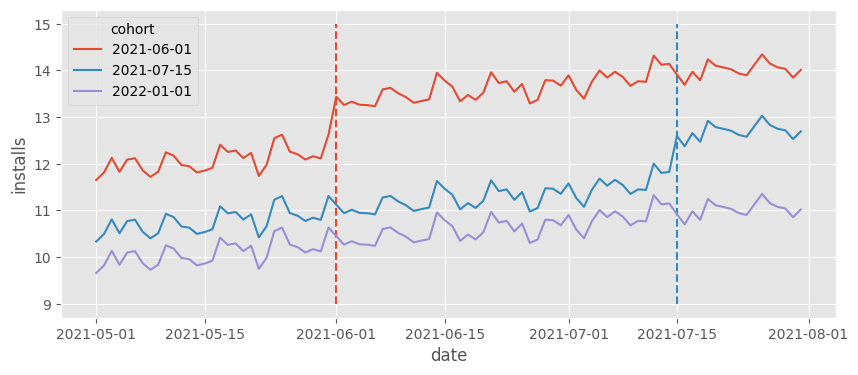

In [28]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

The dashed lines mark the moment a cohort got the treatment (the feature was rolled out). Take a moment to appreciate the richness of the data depicted in the above plot. First, we can see that each cohort has its own baseline level. That's simply because different cities have different population sizes, leading to more or less installs depending on the city size. For instance, it looks like cities in the first cohort (treated in 06/01) have a higher baseline, compared to the cities in the other cohorts. Also, it looks like the control cohort has a lower baseline of intalls. This means that simply comparing treated cohorts against the control cohorts would yield a biased result, since $Y_{0}$ for the control is lower than the $Y_{0}$ for the treated, or $Y_{0}|G=Control < Y_{0}|G=Treated$, where we use $G$ to denote the cohort. Fortunately this won’t be a problem. Panel data allow us to compare across cities **and** time, which allows it to adjust for different baselines.

Speaking of time, notice how there is an overall upward trend with some wiggles (which looks like weekly seasonality). Focusing on the control cohort, it looks like daily installs went from about 10 in May to about 11 in June, an increase of about 1. In technical terms, latter time periods have higher $Y_{0}$ than early time periods. This means that simply comparing the same cities across time would also yield biased results. Once again, we are fortunate that the panel data structure allows us to compare not only across time, but also across cities, adjusting for trends.

Ideally, to infer the effect of the rollout of this new feature on installs, we want to know what would have happened to the cohorts that got the feature, had they not got it. We want to estimate the counterfactual outcome $Y(0)$ in the post treatment periods for the treated cohorts. If we denote each cohort by the time it got treated `g` (remember that a cohort is just a group of cities that got treated at the same time), we can write this counterfactual as $E[Y_0|t\geq g]$, which would then allow us to define the treatment effect on the treated (the ATT) for cohort `g` as follows:

$$
E[Y_1|t \geq g] - E[Y_0|t\geq g]
$$


The next question is how can we estimate this from the data we have. Well, one way is to exploit the power of the panel data structure and estimate those counterfactuals. For instance, we could use linear regression and the Diff-in-Diff formulation to get a Two Way Fixed Effect model. Let's say each city `i` has a base install level $\gamma_i$. This ties back to what we saw earlier: maybe a city has more installs because it has a bigger population or because its culture is more in line with the product from our tech company. Regardless of the reason and even if we don't know why, we say that those unit idiosyncrasies can be captured by a **time fixed parameter** $\gamma_i$. Similarly, we can say that each time period `t` has a baseline install level which we can capture by a **unit fixed parameter** $\theta_t$. If that is the case, a good way of modeling install is to say it depends on the city (unit) effect $\gamma$ and the time effect $\theta$, plus some random noise.

$$
Installs_{it} = \gamma_i + \theta_t + e_{it}
$$

To include the treatment in this picture, let's define a variable $D_{it}$ which is 1 if the unit is treated and zero otherwise. In our example, this variable would be always zero for the never treated cohort. It would also be zero for all the other cohorts at the beginning, but it would turn into 1 at 06/01 for the cohort treated on 06/01 and stay at 1 after that. Also, it would turn into 1 at 07/15 for the cohort treated on 07/15. We can include those treatment indicators in our model of installs as follows:

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

Estimating the above model with OLS is what is called the Two-Way Fixed Effects Model (TWFE). Notice that $\tau$ would be the treatment effect, as it tells us how much installs changes once units are treated.

Another way of looking at it is to invoke the "holding things constant" propriety of linear regression. If we estimate the above model, we could read the estimate of $\tau$ as how much installs would change if we flip the treatment from 0 to 1 while holding the unit `i` and time `t` fixed.

Notice how bold this is! To say we would hold each unit fixed while seeing how $D$ changes the outcome is to say we are controlling for all unit specific characteristics that are constant through time, known and unknown. For example, we would be controlling for cities' baseline install level, which we can measure, but also stuff we have no idea about, like how much a city culture is in line with our product. The only requirement is that this characteristic is fixed over the time of the analysis. Moreover, to say we would hold each time period fixed is to say we are controlling for all year specific characteristics. For instance, since we are holding the year fixed, while looking at the effect of $D$, we would be controlling for the trend and seasonalities we saw earlier.

To see all this power in action all we have to do is run an OLS model with the treatment indicator $D$ (`treat` here), plus dummies for the units and time. In our particular example, I've generated data in such a way that the effect of the treatment (new feature) is to increase installs by 1. Notice how TWFE can recover that treatment effect perfectly:

In [29]:
formula = f"""installs ~ treat + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df).fit()

twfe_model.params["treat"]

1.0000000000000528

Since I've simulated the data above, I know exactly the true individual treatment effect, which is stored in the `tau` column. Since the TWFE should recover the treatment effect on the treated, we can verify that the true ATT matches the one estimated above. All we have to do is filter the treated units and period (`treat==1`) and take the average of the `tau` column.

In [30]:
df.query("treat==1")["tau"].mean()

1.0

Before anyone comes and says that generating one dummy column for each unit is impossible with big data, let me come forward and tell you that, yes, that is true. But there is an easy work around. We can use the FWL theorem to partition that single regression into two. In fact, running the above model is numerically equivalent to estimating the following model

$$
\tilde{Installs}_{it} = \tau \tilde D_{it} + e_{it}
$$

where

$$
\tilde{Installs}_{it} = Installs_{it} - \underbrace{\frac{1}{T}\sum_{t=0}^T Installs_{it}}_\text{Time Average} - \underbrace{\frac{1}{N}\sum_{i=0}^N Installs_{it}}_\text{Unit Average}
$$

and

$$
\tilde{D}_{it} = D_{it} - \frac{1}{T}\sum_{t=0}^T D_{it} - \frac{1}{N}\sum_{i=0}^N D_{it}
$$

In words now, in case the math is too crowded, we subtract the unit average across time (first term) and the time average across units (second term) from both the treatment indicator and the outcome variable to constrict the residuals. This process is oftentimes called de-meaning, since we subtract the mean from the outcome and treatment. Finally, here is the same exact thing, but in code:

In [31]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("date")[col_to_demean].transform("mean"))})


formula = f"""installs ~ treat"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="installs")))

result = mod.fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.4580,6.12e-16,-1.87e+16,0.000,-11.458,-11.458
treat,1.0000,1.54e-15,6.48e+14,0.000,1.000,1.000


Another thing we can do to understand what TWFE model is doing is to plot the counterfactual predictions $\hat{Y_0}|t \geq g$. This is helpful because what our model sees as the treatment effect $\hat{\tau}$ as simply the estimated difference $Y_1 - \hat{Y_0}$. Looking at this explicit difference can shed some light on what the model is doing. In the plot below, we can see exactly that, $\hat{Y_0}$ represented by dotted lines.

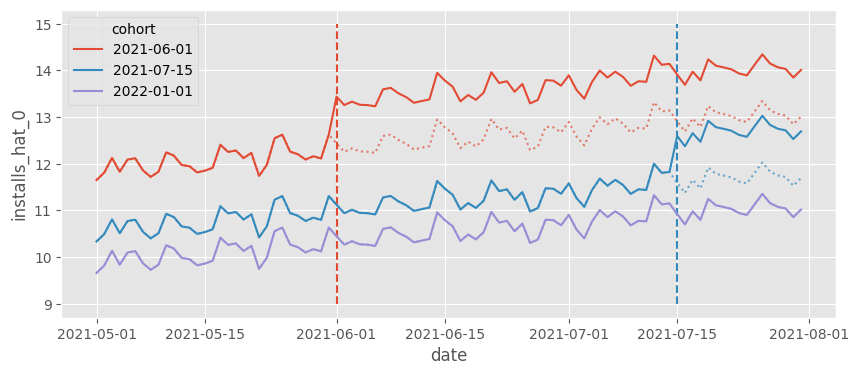

In [32]:
df_pred = df.assign(**{"installs_hat_0": twfe_model.predict(df.assign(**{"treat":0}))})


plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    hue="cohort",
    alpha=0.7,
    ls="dotted",
    legend=None
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

This plot shows us how TWFE is projecting the trend it sees in the control units onto the treated units and it is also adjusting the levels. For example, if we look at the red cohort, the counterfactual $Y_0$ is the average trend from the blue and purple cohorts (trend projection) but shifted to the level of the red cohort (level adjustment). This is why we see TWFE as a Difference-in-Differences method. It also does the trend projection and level adjustment, but it works for multiple time periods and multiple units (in the 2 units by 2 period case, TWFE and DiD are equivalent).

## 2) Death: Failures over Effect Heterogeneity


As we just saw, DiD and TWFE has its merits. It can estimate counterfactuals quite well, accommodating both time and unit specific variations. This makes it a powerful causal inference technique. But if this was all there was to it, we wouldn't need this chapter, as this is very much covered in Part I of this book. What happened recently is that many academics noticed that extending the 2 by 2 DiD to multiple periods with TWFE is not as straightforward as we first thought. In fact, **TWFE, in its usual formulation, turns out to be biased in many real life applications**. This event caused a wave of revisions in multiple studies in economics that relied on this technique. To understand all of that, the best way to start is by stating the underlying assumption.

![img](https://github.com/AluminumShark/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/data/img/did-saga/death.png?raw=1)

For simplicity sake let's consider the FE model without the time effects:

$$
y_{it} = \tau D_{it} + \gamma_i + e_{it}
$$


We can group the assumption this model makes into two groups

1. Functional Form Assumptions:
    * No heterogeneous effects in time (constant effects);
    * Linearity in the covariates;
    * Additive fixed effects.
2. Strict Exogeneity
    * Parallel trends
    * No anticipation
    * No unobserved time varying confounders
    * Past treatment don't affect current outcome (no carryover)
    * Past outcome don't affect current treatment (no feedback)
    
Here, we will stick to the functional form assumptions. Linearity in the covariates is very well known and applies to all linear regression models. But, as we saw with the chapter on Double/Debiased Machine Learning, we can easily relax that assumption with a machine learning model. This means that we can relax this assumption if we wish to do so. As for the additive fixed effect, this is not a too restrictive assumption, so it doesn't cause a lot of problems. The one I want to focus on (and which generated a lot of fuss) is the one about no heterogeneous effects in time.

### Treatment Effect Heterogeneity in Time

If you ever worked with marketing or tech, you know things take time to mature. If you launch a new feature, it will take time for users to get used to it. Similarly, if you start a marketing campaign, the effect of that campaign won't be instantaneous. It will mature over time and perhaps bring new users even after the campaign is over. This is **not** the pattern that we had in install data we've seen earlier. There, installs jumped up instantaneously, at the moment the cohort is treated. What happens if we change that to be more in line with what we see in reality. Namely, let's make it so that the ATT is still 1, but now, it takes 10 days to mature (so it will be 0.1 at the first treatment day, 0.2 at the second treatment day and so on, until it reaches 1 on the 10th day). Also, I'll reduce the size of the time and unit effects so that the overall trend is easier to see.

In [43]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D") # Remove .date
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]) # Remove .date

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1) # Now both d["date"] and d["cohort"] are Timestamp objects
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)


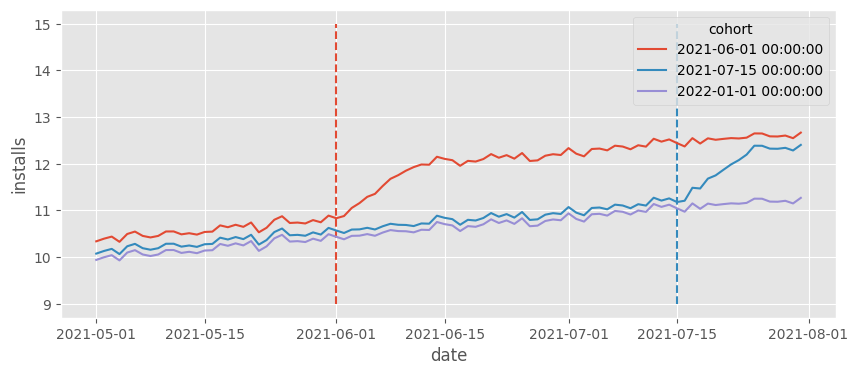

In [44]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_heter
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

What we see is that the installs still reach the same level as they did before, but it takes some time (10 days) for that. This seems reasonable right? Most of the data we see in real life works like that, with effects taking some time to mature. Ok, so let's run TWFE model on this data to see what happens.

In [45]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_heter).fit()

print("Estimated Effect: ", twfe_model.params["treat"])
print("True Effect: ", df_heter.query("treat==1")["tau"].mean())

Estimated Effect:  0.7867708225724899
True Effect:  0.8544117647058823


First, notice that the true ATT is no longer 1. That is because it will be smaller in the first few periods. Second, and most importantly, we can see is that the **estimated ATT from TWFE is not recovering the true ATT** anymore. To put it simply:TWFE is biased. But why is that? We have parallel trends, no anticipation and all the other strict exogeneity assumptions here. So what is going on?

The first step towards understanding what is happening is to realize that TWFE can actually be decomposed into multiple 2 by 2 Diff-in-Diffs. In our example, that would be one that compares early treated to never treated, late treated against never treated, early treated against late treated (with late treated serving as the control) and late treated against early treated (with early treated being the control):

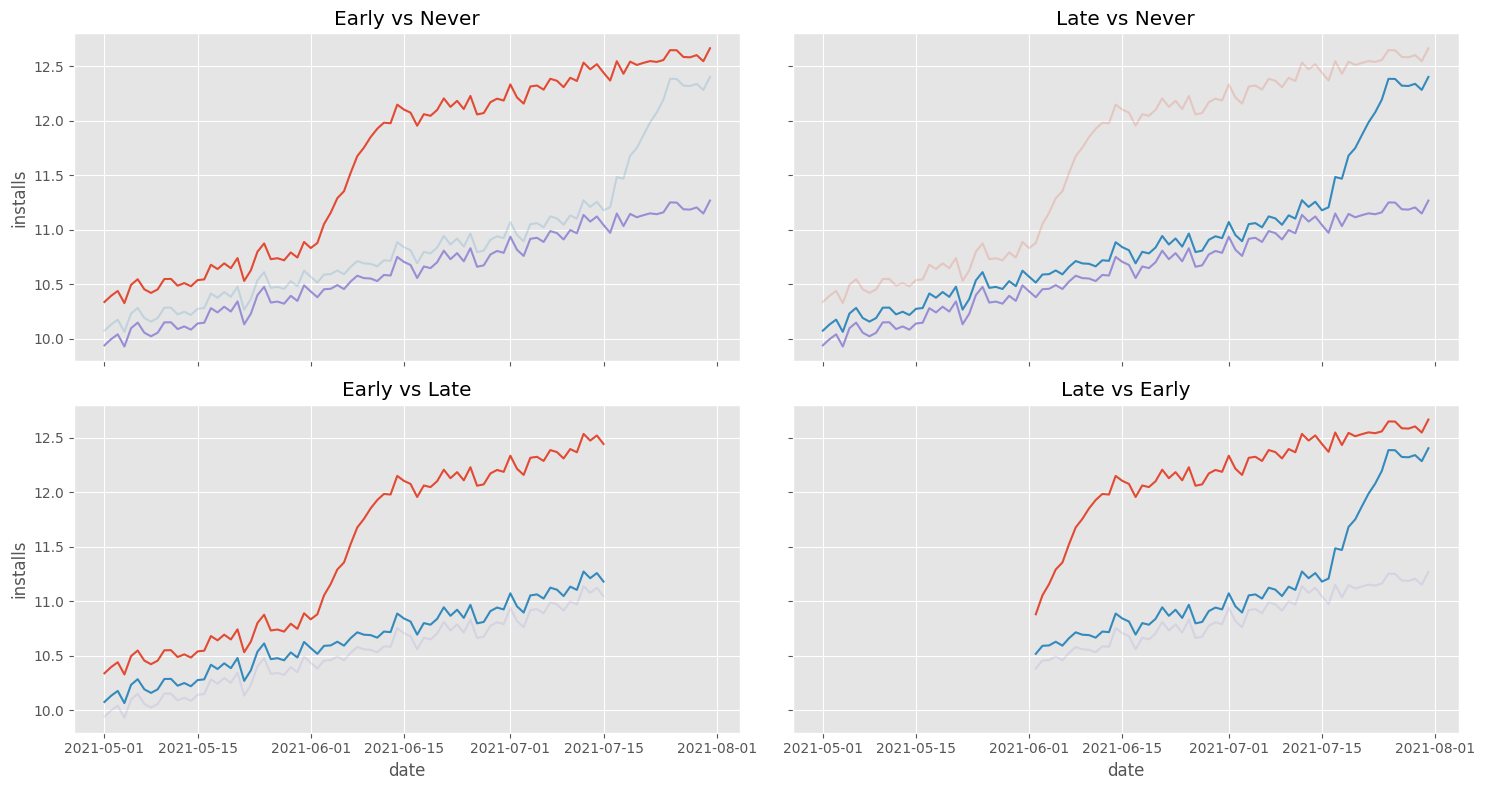

In [49]:
g_plot_data = (df_heter
               .groupby(["cohort", "date"])["installs"]
               .mean()
               .reset_index()
               # .astype({"cohort":str})  # Remove this line, it converts the dates to string
               )


fig, axs = plt.subplots(2, 2, figsize=(15,8), sharex=True, sharey=True)

def plot_comp(df, ax, exclude_cohort, name):

    # Use the datetime objects directly as keys
    palette = dict(zip(cohorts, ["C0", "C1", "C2"]))

    sns.lineplot(
        data=df.query(f"cohort != '{exclude_cohort}'"),
        x="date",
        y="installs",
        hue="cohort",
        palette=palette,
        legend=None,
        ax=ax
    )

    sns.lineplot(
        data=df.query(f"cohort == '{exclude_cohort}'"),
        x="date",
        y = "installs",
        hue="cohort",
        palette=palette,
        alpha=0.2,
        legend=None,
        ax=ax
    )

    ax.set_title(name)

plot_comp(g_plot_data, axs[0,0], cohorts[1], "Early vs Never")
plot_comp(g_plot_data, axs[0,1], cohorts[0], "Late vs Never")

plot_comp(g_plot_data[g_plot_data["date"]<=cohorts[1]], axs[1,0], cohorts[-1], "Early vs Late")
plot_comp(g_plot_data[g_plot_data["date"]>cohorts[0]], axs[1,1], cohorts[-1], "Late vs Early")

plt.tight_layout();

The first three comparisons are no reason for concern, mostly because what they use as control is very well behaved. However, the fourth comparison, late vs early, is problematic. Notice that this comparison uses the early treated as a control. Also notice that this early treated control has a weird behavior. It climbs up sharply at the beginning. That is a reflection of our ATT not being instantaneous, but instead taking 10 days to mature. Intuitively, we can see that this will mess up the estimation of the counterfactual trend in the DiD, making it steeper than it should be. To visualize that, let's plot the estimated counterfactual $Y_0$ for the late treated in this 4th group.

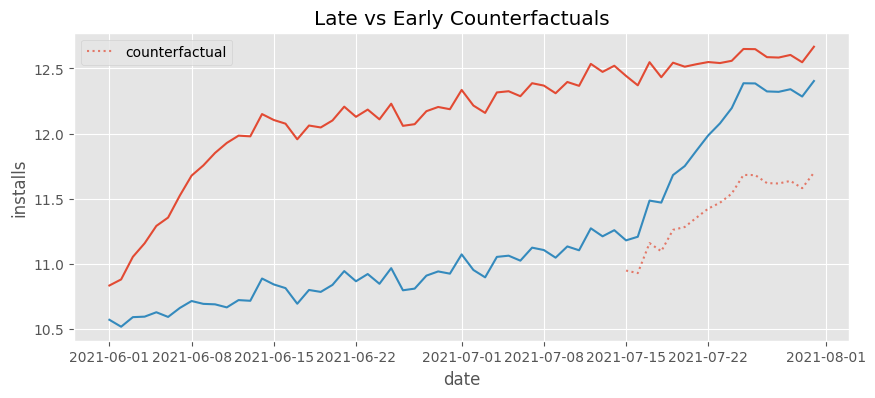

In [50]:
late_vs_early = (df_heter
                 [df_heter["date"].astype(str)>="2021-06-01"]
                 [lambda d: d["cohort"].astype(str)<="2021-08-01"])


formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=late_vs_early).fit()

late_vs_early_pred = (late_vs_early
                      .assign(**{"installs_hat_0": twfe_model.predict(late_vs_early.assign(**{"treat":0}))})
                      .groupby(["cohort", "date"])
                      [["installs", "installs_hat_0"]]
                      .mean()
                      .reset_index())


plt.figure(figsize=(10,4))
plt.title("Late vs Early Counterfactuals")
sns.lineplot(
    data=late_vs_early_pred,
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

sns.lineplot(
    data=(late_vs_early_pred
          [late_vs_early_pred["cohort"].astype(str) == "2021-07-15"]
          [lambda d: d["date"].astype(str) >= "2021-07-15"]
         ),
    x="date",
    y ="installs_hat_0",
    alpha=0.7,
    color="C0",
    ls="dotted",
    label="counterfactual"
);

Just like we said, the counterfactuals have a much steeper trend than it should have. It is capturing that quick increase in the beginning of the early treatment and projecting that trend onto the late treated.

More technically, it can be shown (Goodman-Bacon, 2019) that, even under strict exogeneity (parallel trends, no anticipation...), if the cohorts have the same size, the TWFE estimator will converge to

$$
plim_{x \to \infty} \hat{\tau}^{TWFE} = VWATT - \Delta ATT
$$

The first term is the variance weighted ATT from multiple DiD comparisons like the ones we saw earlier. This is what we want. However, there is also that extra $\Delta ATT$ term there. This represents how much the ATT changes over time and it is what bias our estimate. Looking at this term, we can see that we will have downward bias if the magnitude of the effect increases with time (like in our example) or upward bias if the magnitude of the effect decreases with time.

In the example above, we saw that the effect from TWFE was smaller than the true ATT. But the situation can be even more extreme. I think it is worth going over one last example to see that this bias can be so strong as to even reverse the signal of the true ATT. Let's consider a very simple process, with only two cohorts. Here, the treatment effect will be negative and decreasing by 0.1 every day. I've also removed all time fixed effects and the trend so we can really see what is going on.

In [51]:
date = pd.date_range("2021-05-15", "2021-07-01", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-06-15"])
units = range(1, 100+1)

np.random.seed(1)

df_min = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
)).assign(
    trend = 0,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 - d["trend"] + 0.1*d["unit_fe"]
).assign(
    y1 = lambda d: d["y0"] - 0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days))
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)


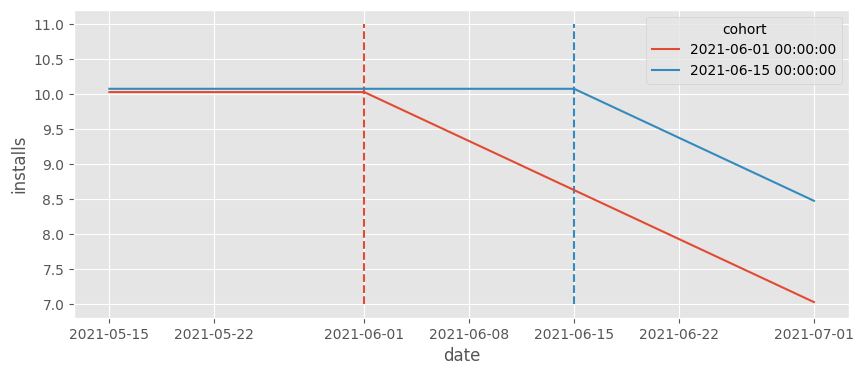

In [52]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_min
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

Looking at the plot above, we can clearly see that the ATT is negative right? The correct counterfactual should be a straight line at about 11. However, if we run the TWFE estimator, we get a positive effect!

In [53]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_min).fit()

twfe_model.params["treat"]

0.04999999999999297

Once again, to see what is going on, focus your attention on the comparison where the early treated cohort serves as the control for the late treated. Remember that, like DiD, TWFE adjusts the trend from the control group to the level of the treated group, so the counterfactual should reflect that.

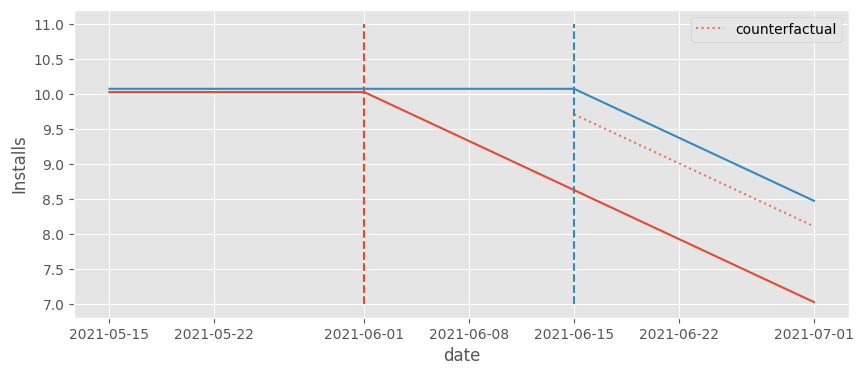

In [54]:
df_pred = df_min.assign(**{"installs_hat_0": twfe_model.predict(df_min.assign(**{"treat":0}))})

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

Notice how the counterfactual level is pushed down from where it should be. The fact that the early treated group effect is decreasing pushed this level down from 10 to about 9.5. Not only that, the counterfactual also adjusts for a downward trend, which should not be there. It is pretty clear from the plot that the right counterfactual should be a straight line at 10, but instead, it is a downward sloping line, since that is what it sees in the early treated group it uses as a control.  

The end result is that the counterfactual $Y_0$ is actually below the $Y_1$ outcome, leading to a positive impact estimation. This is pretty awkward. By simply looking at the plot, we can pretty much see where the right counterfactual should be (the straight line at 10). Still, TWFE cannot recover that simply because it uses the early treated as a control for the late treated.

#### Event Study Design

Just to get it out of the way, I know someone might think we can easily solve this problem by what is called an event study design, where we add one dummy for each period before and after the treatment. In this case, we replace the original TWFE model by

$$
Y_{i,t} = \tau^{-K}~ D_{i,t}^{<-K} + \sum_{k=-K}^{-2} \tau^{lead} D_{i,t}^{k} +\sum_{k=0}^{L} \gamma_k^{lag} D_{i,t}^{k} + \gamma_k^{L+} D_{i,t}^{>L} \gamma_i + e_{it}
$$

where $D^k_{i,t}=1\{t-\text{Cohort}_i=k\}$ is an event study dummy that is 1 if the unit is `k` periods away from the treatment and 0 otherwise. I know this looks messy and complicated, but it is actually very simple once we look at it through some code. All we need to do is create a `relative_days` column which measures how far away is the unit from the period where treatment starts.

In [55]:
df_min_rel = (df_min
              .assign(relative_days = (df_min["date"] - df_min["cohort"]).dt.days))

df_min_rel.head()

,date,unit,cohort,unit_fe,trend,day,treat,y0,y1,tau,installs,relative_days
0,2021-05-15,1,2021-06-15,-3.435864,0,0,0,9.656414,9.656414,0.0,9.656414,-31
1,2021-05-16,1,2021-06-15,-3.435864,0,1,0,9.656414,9.656414,0.0,9.656414,-30
2,2021-05-17,1,2021-06-15,-3.435864,0,2,0,9.656414,9.656414,0.0,9.656414,-29
3,2021-05-18,1,2021-06-15,-3.435864,0,3,0,9.656414,9.656414,0.0,9.656414,-28
4,2021-05-19,1,2021-06-15,-3.435864,0,4,0,9.656414,9.656414,0.0,9.656414,-27


Then, we can pass that column as a category so our model will estimate the expected number of installs for each period relative to the treatment. We can then define the effect as the extra expected number of installs compared to relative day -1, which is the last day prior to the treatment.

We might think that this formulation would capture the time heterogeneity in the ATT and solve all our issues. Unfortunately, that is not the case. If we try it out and plot the counterfactuals, we can see that they are far from where they should intuitively be (the horizontal line at 11).

In [56]:
# remove the intercept, otherwise effects will be relative to relative day -30
formula = f"installs ~ -1 + C(relative_days) + C(date) + C(unit)"

twfe_model = smf.ols(formula, data=df_min_rel).fit()

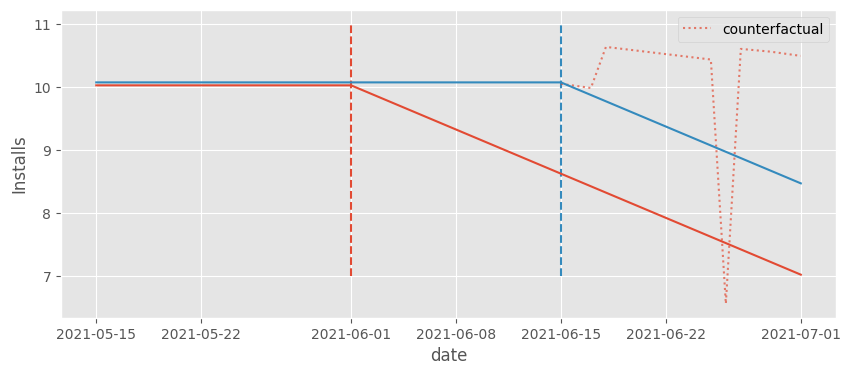

In [57]:
df_pred = df_min_rel.assign(
    installs_hat_0=twfe_model.predict(df_min_rel.assign(relative_days=-1))
)

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

![img](https://github.com/AluminumShark/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/data/img/did-saga/awful.jpeg?raw=1)

These counterfactuals are a bit better, though. We can see that they fall above the realized $Y_1$ outcome. As a result, we will at least estimate a negative effect, as we should. To see that, we can plot the estimated effects by first extracting the parameter associated with each dummy and then subtracting from them the parameter associated with relative day -1 (the baseline).

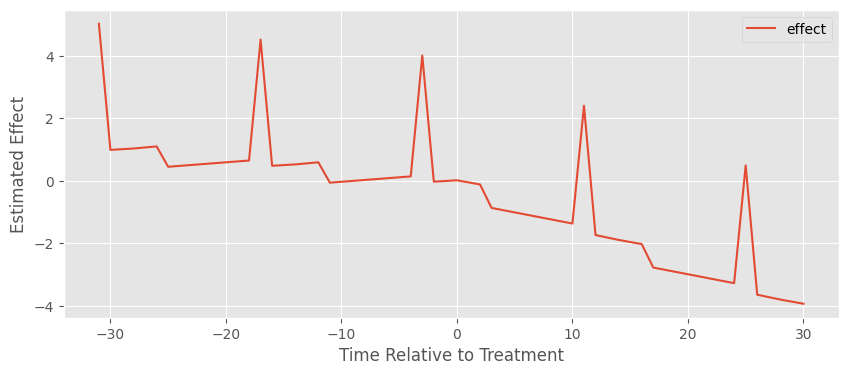

In [58]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("relative_days")]
           .reset_index()
           .rename(columns={0:"effect"})
           .assign(relative_day=lambda d: d["index"].str.extract(r'\[(.*)\]').astype(int))
           # set the baseline to period -1
           .assign(effect = lambda d: d["effect"] - d.query("relative_day==-1")["effect"].iloc[0]))

# effects
effects.plot(x="relative_day", y="effect", figsize=(10,4))
plt.ylabel("Estimated Effect")
plt.xlabel("Time Relative to Treatment");

We can kind of see it is a bit better because at least the estimated effect after the treatment is 1) mostly negative and 2) mostly decreasing. But there are these weird spikes and what looks like a positive pre-treatment effect, which obviously doesn’t make any sense.

The problem here is the same we’ve been discussing. Since we have different timing in the treatment, the early treated gets used as a control for the late treated units, which causes the model to estimate a very weird counterfactual trend. The bottom line is that adding time relative to treatment dummies does not solve the problem, but what does, exactly?

## 3) Enlightenment: A Flexible Functional Form

There are good news and bad news. First, the good news: we've identified the problem as being one related to the functional form, so we can fix it by correcting that form. Namely, we've said over and over that this specific bias in TWFE comes from the time heterogeneous effects. This can happen, among many other reasons, because the effect takes some time to mature (ex: it might take 10 days for a marketing campaign to reach its full potential). In other words, the functional form of traditional TWFE is simply not flexible enough to capture this heterogeneity, leading to the sort of bias we've discussed. Like in most cases, knowing the problem is already a long way in the direction of finding a solution.

In the end of the last section, we saw how simply allowing for a different effect on each time period relative to the treatment (event study design) was not enough. Even though that didn’t work, the intention behind it was good. It did make the model more flexible, but not in a way it solved the problem. We need to think of another way to make the model even more flexible than that.

To do that, let's go back to our original example, when we were trying to model the number of incremental installs that rolling out a new feature (treatment) brought us. We saw that the simple TWFE model does not work here:

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

More than that, we know it doesn't work because it is too restrictive. It forces the effect to be the same \\(\tau_{it}=\tau \ \forall i, t\\), that is, it forces time homogeneity. If that is the problem, an easy fix would be to simply allow for a different effect for each time and unit.

$$
Installs_{it} = \sum_{i=0}^N \sum_{t=0}^T \tau_{it} D_{it} + \gamma_i + \theta_t + e_{it}
$$

This would be equivalent to running the formula below:
```
installs ~ treat:C(unit):C(date) + C(unit) + C(date)
```

Unfortunately, we can't fit that. It would have more parameters than we have data points. Since we are interacting date and unit, we would have one treatment effect parameter for each unit for each time period $T*N$. But this is exactly the number of samples we have! OLS wouldn't even run here.

Ok, now, we need to reduce the number of treatment effect parameters of the model. To achieve that, we can think about a way of somehow grouping units. If we think about this a bit, we can see a very natural way to group units: by cohort! We know that the effect in an entire cohort follows the same pattern over time. So, a natural improvement on that impractical model above is to allow the effect to change by cohort instead of units:

$$
Installs_{it} = \sum_{g=0}^G \sum_{t=0}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

where `G` is the total number of cohorts and `g` marks each individual cohort. That model has a much reasonable number of treatment effect parameters ($T*G$) since $G$ is usually much smaller than $N$. Now, we can finally run it.

In [59]:
formula = f"""installs ~ treat:C(cohort):C(date) + C(unit) + C(date)"""

# for nicer plots latter on
df_heter_str = df_heter.astype({"cohort": str, "date":str})

twfe_model = smf.ols(formula, data=df_heter_str).fit()

To see if this model works, we can make counterfactual predictions for $Y_0$ by forcing `treat` to be zero for everyone. Then, we can estimate the effect by taking the observed outcome for the treatment, which is $Y_1$, and subtract $\hat{Y}_0$ from it. Let's see if that matches the true ATT.

In [60]:
df_pred = (df_heter_str
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str.assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))

print("Number of param.:", len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred. Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

Number of param.: 467
True Effect:  0.8544117647058823
Pred. Effect:  0.8544117647058947


It does! We finally managed to make a model which is flexible enough to capture the time heterogeneity, which allowed us to estimate the correct treatment effect! Another cool thing we can do is extract the estimated effects by time and cohort and plot them. In this case, because we know how the data was generated, we know what to expect. Namely, the effect for each cohort must be zero before treatment, then 1 10 days after treatment and a line climbing up from zero to 1 in the days between the treatment and 10 days after it.

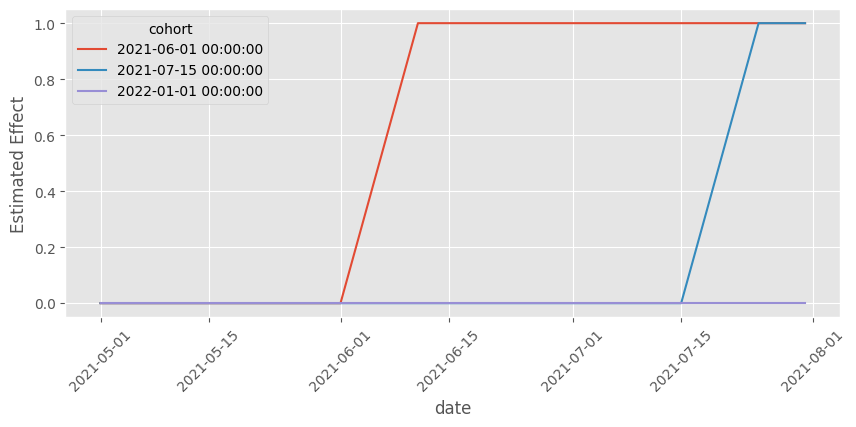

In [61]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'))
           .assign(date=lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date"]), cohort=lambda d: pd.to_datetime(d["cohort"])))

plt.figure(figsize=(10,4))
sns.lineplot(data=effects, x="date", y="param", hue="cohort")
plt.xticks(rotation=45)
plt.ylabel("Estimated Effect");

Once again, the plot above matches our expectations of the effects. They follow the exact pattern we described above.

This is already very good, but we can do even better. First, notice how that model has a huge number of parameters. Since we have 100 units and about 92 days in our data, we know that 192 of those parameters are the unit and time effects. Still, that leaves us with more than 250 treatment effect parameters.

If we assume a zero effect before the treatment (no anticipation), we can reduce the number of parameters by dropping the dates before treatment from the interaction term.

$$
Installs_{it} = \sum_{g=0}^G \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

Also, we can drop from the interaction the control cohorts, since its effect before the treatment is always zero

$$
Installs_{it} = \sum_{G=q}^g \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

where cohorts before $g<q$ are defined as the control cohorts.

Notice however that this is tricky to implement with formulas, so we have to do some feature engineering first. Namely, we will create the cohort dummies by hand, making one column which is 1 when the cohort is `2021-06-01` and 0 otherwise and another column which is 1 when the cohort is `2021-07-15` and 0 otherwise. Also, we will create a date column for cohort `2021-06-01` which collapses all dates before that cohort date to a `control` category. We can do a similar thing with the dates from the `2021-07-15` cohort. Here is what this looks like in code.

In [62]:
def feature_eng(df):
    return (
        df
        .assign(date_0601 = np.where(df["date"]>="2021-06-01", df["date"], "control"),
                date_0715 = np.where(df["date"]>="2021-07-15", df["date"], "control"),)
        .assign(cohort_0601 = (df["cohort"]=="2021-06-01").astype(float),
                cohort_0715 = (df["cohort"]=="2021-07-15").astype(float))
    )

formula = f"""installs ~ treat:cohort_0601:C(date_0601)
                       + treat:cohort_0715:C(date_0715)
                       + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df_heter_str.pipe(feature_eng)).fit()

If we now make counterfactual predictions like before, we can see that the estimated effect is still matching the true effect perfectly. The gain here is that we have a much simpler model, with only about 80 treatment effect parameters (remember that 192 of those parameters are the time and unit fixed effect).

In [63]:
df_pred = (df_heter
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str
                                                           .pipe(feature_eng)
                                                           .assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))


print(len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

271
True Effect:  0.8544117647058823
Pred Effect:  0.8544117647059034


Plotting the treatment effect parameters, we can see how we've removed those from the control cohort and those from the dates before the cohort is treated.

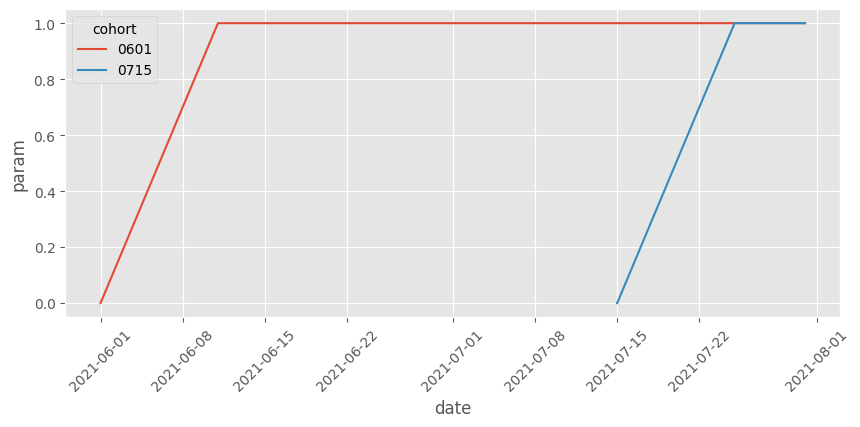

In [64]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r':cohort_(.*):'),
                   date_0601=lambda d: d["index"].str.extract(r':C\(date_0601\)\[(.*)\]'),
                   date_0715=lambda d: d["index"].str.extract(r':C\(date_0715\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date_0601"].combine_first(d["date_0715"]), errors="coerce")))


plt.figure(figsize=(10,4))
sns.lineplot(data=effects.dropna(subset=["date"]), x="date", y="param", hue="cohort")
plt.xticks(rotation=45);

Notice that we could go even further, since the effect for both cohorts follow the same shape. Namely, we could restrict the model to have the same effect for both cohorts, changing only over time. To do that, we would need to create a column to represent days after the treatment, just like in the event study design. It would be something like this:
```
days_after_treat=1(date>cohort)*(date - cohort)
```
Then, we would interact it with the treatment indicator
```
installs ~ treat:C(days_after_treat) + C(unit) + C(date)
```
However, I think we can stop here. Not allowing heterogeneity by cohort is, more often than not, a bad idea, since treatment effect tends to change over calendar time, not only over time since the treatment. For example, it could be that, after some time, competitors copy our feature making it no longer a strong customer attractor as it once was. In that case, the effect of the new feature on installs would diminish over time.

One last thing we should do besides showing the effects over time is to plot the counterfactuals to see if they are in a place that feels right. I know this is not a very scientific validation of our model, but trust me, it helps a tone. So here it is.

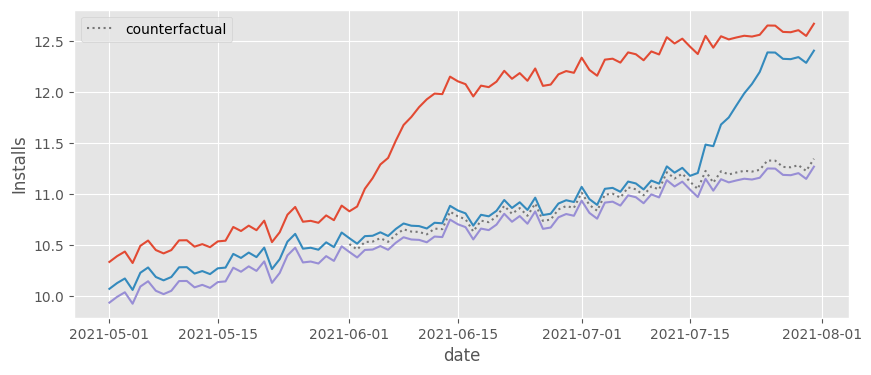

In [65]:
twfe_model_wrong = smf.ols("installs ~ treat + C(date) + C(unit)",
                           data=df_pred).fit()


df_pred = (df_pred
           .assign(**{"installs_hat_0_wrong": twfe_model_wrong.predict(df_pred.assign(**{"treat":0}))}))


plt.figure(figsize=(10,4))
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-01")]
          .groupby(["date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    ls="dotted",
    color="C3",
    label="counterfactual",
)

sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

plt.ylabel("Installs");

As we can see, the counterfactual $Y_0$ prediction falls right where we think it should fall, that is, pretty close to the control cohort. This is very comforting. We know that the TWFE model is estimating the treatment effect as $Y-\hat{Y_0}$. That is, it is simply comparing the outcome from the treated cohorts to that counterfactual. Since the counterfactual seems OK, we can rest assured that the treatment effect is also probably OK.

That is the good news, but don’t think I forgot about the bad news I’ve promised you. The thing is that, although we’ve solved the functional form problem with TWFE, there is still an arguably bigger problem with DiD and TWFE, which is related to its independence assumption.

When using DiD and TWFE, we often invoke the parallel trends assumption, without really thinking about what exactly that assumption means. Sadly, the parallel trends assumption is much more restrictive and less plausible than most people realize	. But since this chapter is already too big, I think it's fine to end it here, where we can still enjoy the taste of a small victory for DiD.

## Key Concepts

I think it is safe to say that we've finally managed not only to understand, but to correct the functional form problem with TWFE. We traced the problem down to its roots (time heterogeneity) and fixed it by allowing for more flexibility. We can now grab ourselves a drink and relax, knowing that TWFE is once again safe to use. Or is it?!

![img](https://github.com/AluminumShark/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/data/img/did-saga/twfeworking.png?raw=1)

We can never forget that TWFE (and DiD more generally) is a mix of **both functional form and independence assumptions**. In this chapter, we've only tackled the functional form problems, but there is still a big elephant in the room: the parallel trend assumption. Parallel trends is the independence assumption DiD makes. This is very well known. But I feel we don't really understand what this assumption implies. We just invoke it out of thin air as if that would make it true. Unfortunately, the parallel trend assumption requires much more than what most people realize. In the next chapters, we will see why that is and what or if we can do something about it.

## Reference


It took a (very) long time to write this chapter. The recent econometric literature has been sprouting with new ideas and insights on the problems related to DiD and how to solve them. There are multiple angles we can see those problems, which in turn leads to multiple approaches we can leverage to solve them. Brace yourselves because the reference list here will be long (and probably not very well organized).

First, I took a lot from *Difference-in-Differences with Variation in Treatment Timing*, by Andrew Goodman-Bacon. His diagnosis of the problem is very neat and intuitive. Not to mention it comes with very nice pictures that gave me a clear understanding on how to understand what was happening with DiD. Some of the pictures in this chapter are almost a direct copy from those made by Goodman-Bacon.

The second major source of inspiration was *Difference-in-Differences with Multiple Time Periods*, by Pedro H. C. Sant'Anna and Brantly Callaway. Notice that the Callaway and Sant'Anna solution to this problem goes on a different route than the one we took. Still, their solution shines a lot of light on the DiD problem, making it easy to understand. The paper aside, Pedro has a very nice blog post showing the problems with TWFE. The Data Generating Process on that blog post heavily inspired the ones that I've used here. I’ve basically translated Pedro’s code from R to Python. Pedro was also very kind in helping me with some questions I had about the DiD assumptions. He has another very interesting article tackling the problem of adding covariates to the DiD models, which we didn’t cover here because the chapter was already too long. The name of the paper is *Doubly Robust Difference-in-Differences Estimators* and I strongly recommend you read it if you plan to add covariates to your model.

Last, but definitely not least, the functional form fix we employed here was inspired on *Estimating dynamic treatment effects in event studies with heterogeneous treatment effects*, by Sun and Abraham and on *Two-Way Fixed Effects, the Two-Way Mundlak Regression, and Difference-in-Differences Estimators*, by Jeffrey Wooldridge. Although I've loved what Callaway and Sant'Anna did on their paper, their solution is a bit more complicated to implement. In contrast, Sun, Abraham and Wooldridge's solution involves nothing more than cleverly playing with interactions in a TWFE regression model, making it super easy to implement using nothing more than `statsmodels` and some formulas.

Aside from the papers mentioned above, I've also relied on presentations given at the DiD Study Group, organized by Taylor Wright on Youtube. It is much easier to understand the articles mentioned above if you first watch the authors talk about them. I'm also very thankful for professor Yiqing Xu for tying all of this together in his amazing Causal Inference with Panel Data lecture series, also available on Youtube.

Finally, keep in mind that I too am also learning, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.


## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).